In [152]:
from datasets import load_dataset

# There is only one split on the hub
dataset = load_dataset("OGB/ogbg-molhiv")

dataset = dataset.shuffle(seed=0)


Found cached dataset json (/home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-1688f3a3aa9acbbd.arrow
Loading cached shuffled indices for dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-b117291977bf1456.arrow
Loading cached shuffled indices for dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-f08fb17f8a35b3d7.arrow


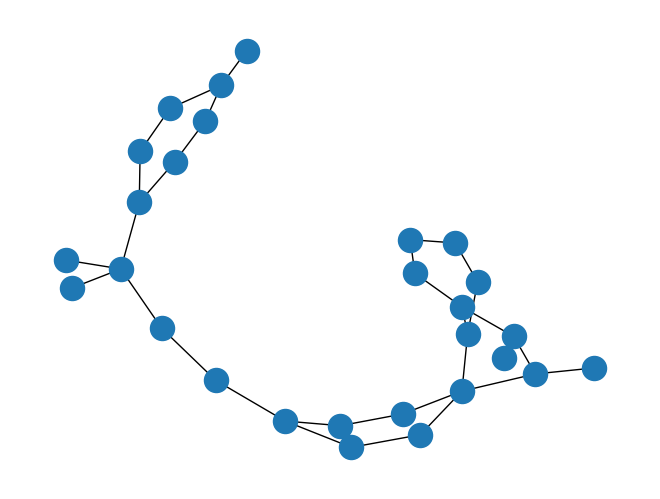

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# We want to plot the first train graph
graph = dataset["train"][0]

edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

# Conversion to networkx format
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

# Plot
nx.draw(G)


In [281]:
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

dataset_processed = dataset.map(preprocess_item, batched=False)


Loading cached processed dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-49407c506b7c3edb.arrow
Loading cached processed dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-121409022ee691f7.arrow
Loading cached processed dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-b34d0a7acd75a063.arrow


In [298]:
from transformers import GraphormerForGraphClassification

model = GraphormerForGraphClassification.from_pretrained(
    "clefourrier/pcqm4mv2_graphormer_base",
    num_classes=1, # num_classes for the downstream task 
    ignore_mismatched_sizes=True,
)


In [299]:
import torch

class GATHead(torch.nn.Module):

    def __init__(self, graphormerModel):
        super(GATHead, self).__init__()

        self.graph_encoder = graphormerModel.graph_encoder
        self.lm_head_transform_weight = graphormerModel.lm_head_transform_weight

    def forward(self, x):
        x, graph_rep = self.graph_encoder(**x)
        x = x[-1].transpose(0, 1)        
        x = self.lm_head_transform_weight(x)
        return x

custom_model = GATHead(model.encoder)

In [300]:
custom_model

GATHead(
  (graph_encoder): GraphormerGraphEncoder(
    (dropout_module): Dropout(p=0.0, inplace=False)
    (graph_node_feature): GraphormerGraphNodeFeature(
      (atom_encoder): Embedding(4609, 768, padding_idx=0)
      (in_degree_encoder): Embedding(512, 768, padding_idx=0)
      (out_degree_encoder): Embedding(512, 768, padding_idx=0)
      (graph_token): Embedding(1, 768)
    )
    (graph_attn_bias): GraphormerGraphAttnBias(
      (edge_encoder): Embedding(1537, 32, padding_idx=0)
      (edge_dis_encoder): Embedding(131072, 1)
      (spatial_pos_encoder): Embedding(512, 32, padding_idx=0)
      (graph_token_virtual_distance): Embedding(1, 32)
    )
    (emb_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-11): 12 x GraphormerGraphEncoderLayer(
        (dropout_module): Dropout(p=0.0, inplace=False)
        (activation_dropout_module): Dropout(p=0.1, inplace=False)
        (activation_fn): GELUActivation()
        (self_attn): Gr

In [287]:
collator = GraphormerDataCollator()
data = collator([dataset_processed['validation'][0]])
data.keys()

dict_keys(['attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'input_nodes', 'input_edges', 'out_degree', 'labels'])

In [302]:
for k,v in data.items():
    print(k, '\t', v.shape)

attn_bias 	 torch.Size([1, 48, 48])
attn_edge_type 	 torch.Size([1, 47, 47, 3])
spatial_pos 	 torch.Size([1, 47, 47])
in_degree 	 torch.Size([1, 47])
input_nodes 	 torch.Size([1, 47, 9])
input_edges 	 torch.Size([1, 47, 47, 22, 3])
out_degree 	 torch.Size([1, 47])
labels 	 torch.Size([1])


In [253]:
data.pop('labels')
# data.pop('attn_bias')

tensor([0])

In [254]:
out = custom_model(data)

In [258]:
out.size()

torch.Size([1, 48, 768])